# Interpolate hybrid sigma pressure coordinates to pressure

Quite a few models usee hybrid sigma coordinates which means that the pressure level follows the surface close to the surface, before becoming less and  influenced by it further up. This is to make it easier numerically to solve the equations. See e.g. here: [link](https://www2.cesm.ucar.edu/models/atm-cam/docs/usersguide/node25.html)

This means that if we want to e.g. average over a specific pressure level, we have to first interpolate to pressure levels. This is done in the below for an example with CMIP6. It's not a given however that this works for any model, so adjustments might have to be made based on the models vertical coordinates. 

In [1]:
from geocat.comp.interpolation import interp_hybrid_to_pressure

In [2]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar


### Open CMIP6 online catalog

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60



### Search corresponding data 

Please check [here](https://pangeo-data.github.io/escience-2022/pangeo101/data_discovery.html?highlight=cmip6) for info about CMIP and variables :) 

Particularly useful is maybe the variable search which you find here: https://clipc-services.ceda.ac.uk/dreq/mipVars.html 

In [4]:
cat = col.search(source_id=['CESM2'], 
                 experiment_id=['historical'], 
                 table_id=['AERmon'], 
                 variable_id=['mmrso4' ], 
                 member_id=['r1i1p1f1'])
cat.df


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


### Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
list(dset_dict.keys())

['CMIP.NCAR.CESM2.historical.AERmon.gn']

In [7]:
ds = dset_dict['CMIP.NCAR.CESM2.historical.AERmon.gn']

### Sub select time period (to make calculations faster):

In [8]:
ds = ds.sel(time=slice('2000','2000'))

In [9]:
hybm= ds['b']
hyam = ds['a']
ds['lev'] = np.abs(ds['lev'])*100
lev_values = ds['lev']



In [10]:
da = ds['mmrso4']
da

<xarray.DataArray 'mmrso4' (member_id: 1, dcpp_init_year: 1, time: 12, lev: 32,
                            lat: 192, lon: 288)> Size: 85MB
dask.array<getitem, shape=(1, 1, 12, 32, 192, 288), dtype=float32, chunksize=(1, 1, 10, 32, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat             (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lev             (lev) float64 256B 364.3 759.5 ... 9.763e+04 9.926e+04
  * lon             (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * time            (time) object 96B 2000-01-15 12:00:00 ... 2000-12-15 12:0...
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Dry mass of sulfate (SO4) in aerosol particles as a fract...
    description:    Dry mass of sulfate (SO4) in aerosol particles as a fract...
    frequency:      mon
    id:             mmrso4
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Aerosol Sulfate Mass Mixing Ratio
    type:           real
    units:          kg kg-1
    variable_id:    mmrso4

In [11]:
ds['p0'].load()

<xarray.DataArray 'p0' ()> Size: 4B
array(100000., dtype=float32)
Attributes:
    long_name:  vertical coordinate formula term: reference pressure
    units:      Pa

In [12]:
ds = ds.squeeze()

In [13]:
da_int = interp_hybrid_to_pressure(ds['mmrso4'],
                                   ds['ps'], 
                                   ds['a'], 
                                   ds['b'], 
                                   p0=ds['p0'],
                                   new_levels=ds['lev'].values, 
                                   lev_dim = 'lev')

In [14]:
da_mean = ds['mmrso4'].mean('time')
with ProgressBar():
    da_mean.compute()

[########################################] | 100% Completed | 3.52 ss


In [15]:
da_int_mean = da_int.mean('time')
with ProgressBar():
    da_int_mean.compute()

[##################################      ] | 85% Completed | 4.66 s ms

/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/geocat/comp/interpolation.py:137: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)


[########################################] | 100% Completed | 5.87 s


Text(0.5, 1.0, 'Pressure levels')

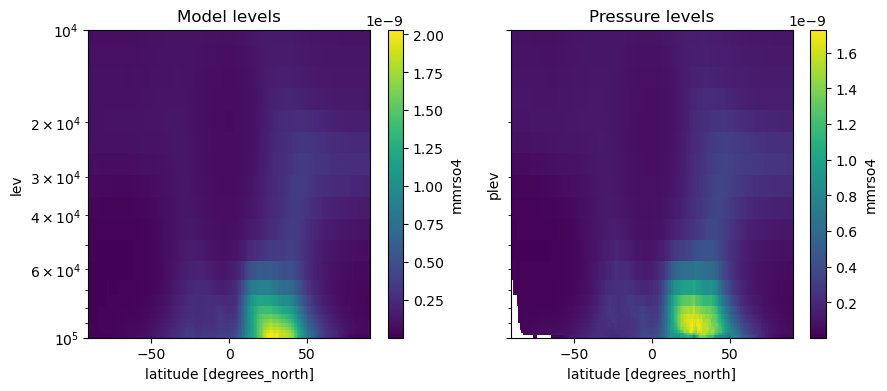

In [16]:
fig, axs = plt.subplots(1,2, sharey = True, figsize=[10,4])
ax = axs[0]
da_mean.mean('lon').plot(ylim=[1000e2,100e2], yscale='log', ax=ax)
ax.set_title('Model levels')
ax = axs[1]
da_int_mean.mean('lon').plot(ylim=[1000e2,100e2], yscale='log', ax=ax)
ax.set_title('Pressure levels')